# Feature Engineering and Preprocessing

## Importing Libraries and Loading Data

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../utils')

from MDLP import MDLP_Discretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [74]:
df = pd.read_csv('../data/processed/sales_cleaned.csv')
df.head()

,X1_cor_sales_in_vol,X2_cor_sales_in_val,X3_CA_mag,X4_value,X6_VenteConv,X5_ENSEIGNE,X7_Feature,Y_Display
0,2.0,20.20,47400,36,72.0,CORA,No_Feat,No_Displ
1,2.0,11.90,62000,24,48.0,LECLERC,No_Feat,No_Displ
2,8.0,29.52,60661,60,480.0,AUCHAN,No_Feat,No_Displ
3,2.0,16.20,59677,19,38.0,CARREFOUR,No_Feat,No_Displ
4,5.0,62.10,142602,50,250.0,CORA,No_Feat,No_Displ


## Preprocessing

Before applying any machine learning model on our dataset, we'll want to compare between two versions of the data, one using the original numerical features, and one using a categorical version of these features, by binning them based on the information gain criterion. This process is called MDLPC.  
Let's create our preprocessors We'll mainly have two:
- OHE for categorical features followed by a standard scaler for the numerical features.
- OHE for categorical features followed by a MDLP discretizer for the numerical features.

### Discretization

We'll use the MDLP discretizer from this [MDLPC implementation](https://github.com/navicto/Discretization-MDLPC).  
Because of the way the discretizer is implemented, we'll have to separate the numerical features from the categorical ones, and then concatenate them back together after the discretization.

In [94]:
X, y = df.drop('Y_Display', axis=1).values, df['Y_Display'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_num, X_train_cat = X_train[:, :5].astype('float'), X_train[:, 5:]
X_test_num, X_test_cat = X_test[:, :5].astype('float'), X_test[:, 5:]

In [98]:
# one-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

# combine numerical and categorical features (no discretization)
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

In [100]:
pd.DataFrame(X_train, columns=list(df.columns[:-3])+list(ohe.get_feature_names_out(input_features=['X5', 'X7']))).to_csv('../data/processed/X_train.csv', index=False)
pd.DataFrame(X_test, columns=list(df.columns[:-3])+list(ohe.get_feature_names_out(input_features=['X5', 'X7']))).to_csv('../data/processed/X_test.csv', index=False)

In [86]:
# discretize numerical features
mdlp = MDLP_Discretizer(features=[0, 1, 2, 3, 4])
mdlp.fit(X_train_num, y_train)
X_train_num_discretized = mdlp.transform(X_train_num)
X_test_num_discritized = mdlp.transform(X_test_num)

# combine numerical and categorical features (discretized)
X_train_discretized = np.concatenate((X_train_num_discretized, X_train_cat), axis=1)
X_test_discretized = np.concatenate((X_test_num_discritized, X_test_cat), axis=1)

In [101]:
pd.DataFrame(X_train_discretized, columns=list(df.columns[:-3])+list(ohe.get_feature_names_out(input_features=['X5', 'X7']))).to_csv('../data/processed/X_train_discretized.csv', index=False)
pd.DataFrame(X_test_discretized, columns=list(df.columns[:-3])+list(ohe.get_feature_names_out(input_features=['X5', 'X7']))).to_csv('../data/processed/X_test_discretized.csv', index=False)

In [89]:
pd.Series(y_train, name='Y_Display').to_csv('../data/processed/y_train.csv', index=False)
pd.Series(y_test, name='Y_Display').to_csv('../data/processed/y_test.csv', index=False)

### Analyzing binning results

Let's look at how the discretizer binned our numerical features for a better separation between the classes.

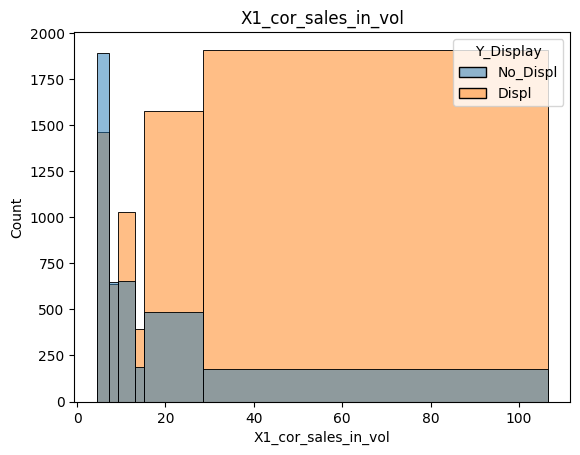

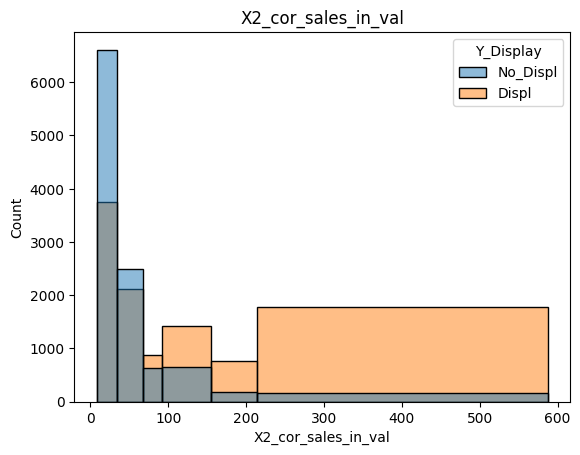

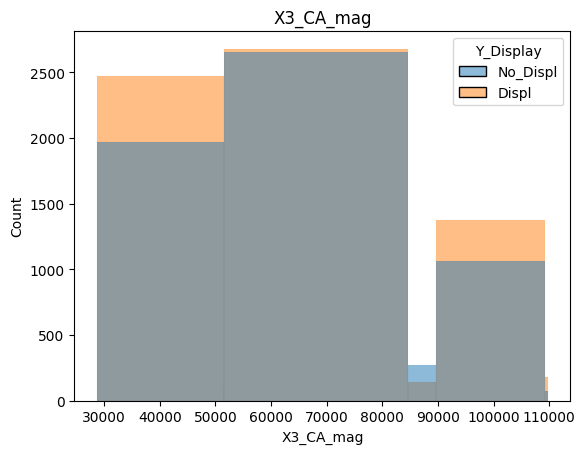

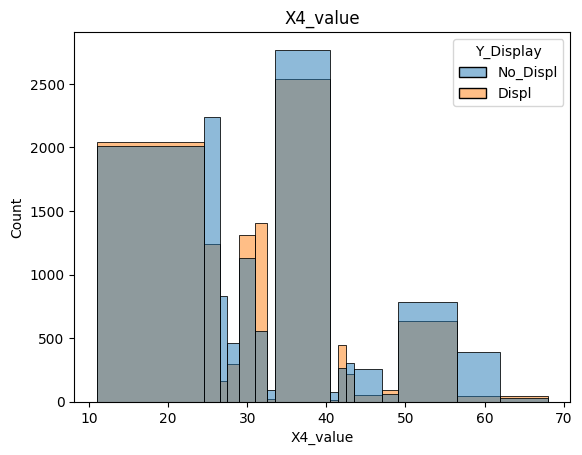

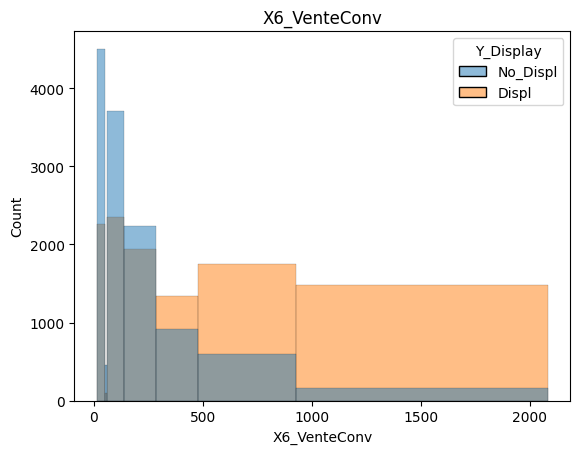

In [106]:
numerical_features = list(df.columns[:5])
for index, feature in enumerate(numerical_features):
    sns.histplot(data=df, x=feature, hue='Y_Display', bins=mdlp._cuts[index])
    plt.title(feature)
    plt.show()

We see that for the first, second and sixth features, the discretizer did a good job at separating the classes, while for the third and fourth features, given the weak correlation between them and the target, we see that some intervals are better than others in terms of class separation, but we don't see a significant difference in the distributions.

## Conslusion

- We see that the MDLP discretizer did a good job at separating the classes for some features, while for others, it didn't do much.
- We have saved our preprocessed dataframes, one with the original numerical features, and one with the discretized numerical features, for later use. Recall that categorical features are one-hot encoded in both dataframes.